# Fetal Health Classification

Patrick Weatherford

***


## Overview

> For this analysis I will be using fetal and maternal vitals from Cardiotocography readings (CTGs) and create a predictive model to classify fetal health based on these readings. The data for this analysis was retrieved from Kaggle but comes from research for a patented program called SisPorto 2.0 which aims to automates the analysis for Cardiotocography readings using various algorithms. The end goal of the program is to provide a machine that not only takes vitals but also interprets the results. Based on the readings from the CTG, 3 experts in the field of study classfied the fetal health based on the output.
<br><br>

> A CTG works by taking readings of cardiac vitals in newborns and maternal readings of the mother (e.g., blood pressure, contractions, etc.). The vitals are then overlayed on top of each other to help visualize how the maternal vitals are affecting fetal cardiac vitals. The machine itself is inexpensive but the results require medical expertise to interpret which is not a common commodity in developing countries. 
<br><br>

> In developing countries, mortality rates in both maternal mothers and newborns are typically higher than more advanced countries which is caused by lack of medical technologies and resources. During labor, many mortalities could potentially be prevented in these developing countries if there was a technology that notified healthcare providers of potential issues with the fetus and/or maternal mother without a need for an expert to interpret the results. Also, for this technology to be effective in these developing countries, it would need to be both cost efficient and effective. If accurate predictive modeling could be accomplished via a CTG, this technology could be one that is both cost-efficient and effective at reducing preventable mortalities in fetal and maternal mothers. 


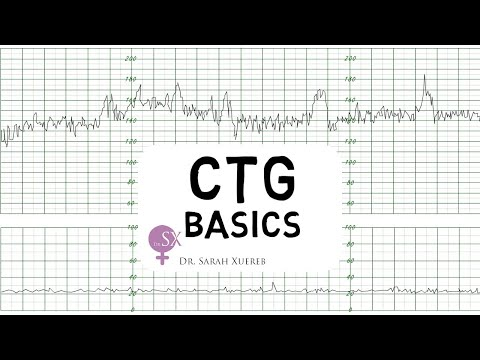

In [1]:
## Embedded YouTube video explaining a CTG
from IPython.display import YouTubeVideo
YouTubeVideo('I5Dj9vKhlMQ', width=800, height=500)

<br>

### Features

In [2]:
import pandas as pd
feature_target_df = pd.DataFrame({
    'baseline value':'FHR baseline (beats per minute)',
    'accelerations':'Number of accelerations per second',
    'fetal_movement':'Number of fetal movements per second',
    'uterine_contractions':'Number of uterine contractions per second',
    'light_decelerations':'Number of LDs per second',
    'severe_decelerations':'Number of SDs per second',
    'prolongued_decelerations':'Number of PDs per second',
    'abnormal_short_term_variability':'Percentage of time with abnormal short term variability',
    'mean_value_of_short_term_variability':'Mean value of short term variability',
    'percentage_of_time_with_abnormal_long_term_variability':'Percentage of time with abnormal long term variability',
    'mean_value_of_long_term_variability':'Mean value of long term variability',
    'histogram_width':'Width of the histogram made using all values from a record',
    'histogram_min':'Histogram minimum value',
    'histogram_max':'Histogram maximum value',
    'histogram_number_of_peeks':'Number of peaks in the exam histogram',
    'histogram_number_of_zeroes':'Number of zeroes in the exam histogram',
    'histogram_mode':'Hist mode',
    'histogram_mean':'Hist mean',
    'histogram_median':'Hist median',
    'histogram_variance':'Hist variance',
    'histogram_tendency':'Histogram trend'
}, index=[0]).T

feature_target_df = feature_target_df.rename(columns={0:'Description'})
feature_target_df.index.name = 'Features'

feature_target_df


,Description
Features,
baseline value,FHR baseline (beats per minute)
accelerations,Number of accelerations per second
fetal_movement,Number of fetal movements per second
uterine_contractions,Number of uterine contractions per second
light_decelerations,Number of LDs per second
severe_decelerations,Number of SDs per second
prolongued_decelerations,Number of PDs per second
abnormal_short_term_variability,Percentage of time with abnormal short term va...
mean_value_of_short_term_variability,Mean value of short term variability


<br>

### Target


>**fetal_health**:
- 1-Normal
- 2-Suspect
- 3-Pathological

***

<br>

## Import Modules

Mount Google Drive to Colab session

In [3]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<br>Install necessary modules not pre-installed by Colab

In [4]:
%%capture
!pip install python-Levenshtein
!pip install fuzzywuzzy


<br>Copy custom packages/moduls over to default path where python packages are installed for this Colab session.

In [5]:
import os
import site
import shutil

# create custom modules folder in default pkg location
dest_path = site.getsitepackages()[0]  # get path where packages are installed
colab_cust_mod_path = f"{dest_path}/hakuna_patata_modules"

if not os.path.exists(colab_cust_mod_path):
    os.makedirs(colab_cust_mod_path)

# create init file in custom modules folder
with open(f"{colab_cust_mod_path}/__init__.py", 'w') as f:
    pass

mods = ['api_keys.py', 'hakuna_patata.py']  # modules to copy over

mod_path = r'/content/drive/MyDrive/Bellevue_University/Python/Custom_Modules'

for mod in mods:
    file_path = f"{mod_path}/{mod}"
    shutil.copy2(file_path, colab_cust_mod_path)


In [6]:
import hakuna_patata_modules.api_keys as api_keys
import hakuna_patata_modules.hakuna_patata as hakuna_patata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import itertools
from zipfile import ZipFile

from google.colab import data_table
data_table.enable_dataframe_formatter()
data_table.DataTable.max_columns = 30

rng = np.random.default_rng(seed=777)


***

<br>

## Import Data

Create directory for kaggle dataset to download to.

In [7]:
kaggle_download_path = r'/content/kaggle_datasets'

if not os.path.exists(kaggle_download_path):
    os.makedirs(kaggle_download_path)


In [8]:
kaggle_username = api_keys.Kaggle_API['username']
kaggle_api_key = api_keys.Kaggle_API['key']
kaggle_dataset = r'andrewmvd/fetal-health-classification'

## Create kaggle api object
kaggle_api_obj = hakuna_patata.kaggle_api(username=kaggle_username, api_key=kaggle_api_key)

kaggle_api_obj.dataset_download_files(kaggle_dataset, kaggle_download_path, force=True, unzip=False)


In [9]:
kaggle_ds_file = r'/content/kaggle_datasets/fetal-health-classification.zip'

zip_df_dict = {}
with ZipFile(kaggle_ds_file) as zf:
    for csv in zf.namelist():
        zip_df_dict[csv] = pd.read_csv(zf.open(csv))

for k, v in zip_df_dict.items():
    print(f"{k}: {v.shape}")


fetal_health.csv: (2126, 22)


In [10]:
initial_fetal_df = zip_df_dict['fetal_health.csv']

initial_fetal_df

Output hidden; open in https://colab.research.google.com to view.

In [11]:
initial_fetal_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2126 entries, 0 to 2125
Data columns (total 22 columns):
 #   Column                                                  Non-Null Count  Dtype  
---  ------                                                  --------------  -----  
 0   baseline value                                          2126 non-null   float64
 1   accelerations                                           2126 non-null   float64
 2   fetal_movement                                          2126 non-null   float64
 3   uterine_contractions                                    2126 non-null   float64
 4   light_decelerations                                     2126 non-null   float64
 5   severe_decelerations                                    2126 non-null   float64
 6   prolongued_decelerations                                2126 non-null   float64
 7   abnormal_short_term_variability                         2126 non-null   float64
 8   mean_value_of_short_term_variability  

*No null values for any features and target*

<br>

In [12]:
initial_fetal_df.describe().T

,count,mean,std,min,25%,50%,75%,max
baseline value,2126.0,133.303857,9.840844,106.0,126.000,133.000,140.000,160.000
accelerations,2126.0,0.003178,0.003866,0.0,0.000,0.002,0.006,0.019
fetal_movement,2126.0,0.009481,0.046666,0.0,0.000,0.000,0.003,0.481
uterine_contractions,2126.0,0.004366,0.002946,0.0,0.002,0.004,0.007,0.015
light_decelerations,2126.0,0.001889,0.002960,0.0,0.000,0.000,0.003,0.015
severe_decelerations,2126.0,0.000003,0.000057,0.0,0.000,0.000,0.000,0.001
prolongued_decelerations,2126.0,0.000159,0.000590,0.0,0.000,0.000,0.000,0.005
abnormal_short_term_variability,2126.0,46.990122,17.192814,12.0,32.000,49.000,61.000,87.000
mean_value_of_short_term_variability,2126.0,1.332785,0.883241,0.2,0.700,1.200,1.700,7.000
percentage_of_time_with_abnormal_long_term_variability,2126.0,9.846660,18.396880,0.0,0.000,0.000,11.000,91.000


***

<br>

## Visualize Data

### Correlation Heatmap/Table

Creating heatmap using pandas.

In [13]:
fetal_df = initial_fetal_df

corr_df = fetal_df.corr()

corr_df.style.background_gradient(cmap='coolwarm')

,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,mean_value_of_long_term_variability,histogram_width,histogram_min,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency,fetal_health
baseline value,1.000000,-0.080560,-0.033436,-0.146373,-0.159032,-0.053518,-0.104597,0.305570,-0.279607,0.285630,-0.032091,-0.147679,0.361619,0.275110,-0.113933,-0.004745,0.708993,0.723121,0.789246,-0.133938,0.293503,0.148151
accelerations,-0.080560,1.000000,0.048235,0.089674,-0.108615,-0.043018,-0.127749,-0.279577,0.207170,-0.373943,-0.142363,0.298631,-0.154286,0.394147,0.190452,-0.006147,0.243610,0.270334,0.272849,0.125704,0.028420,-0.364066
fetal_movement,-0.033436,0.048235,1.000000,-0.068779,0.049228,-0.010976,0.265922,-0.103715,0.121314,-0.074096,0.011047,0.162790,-0.153917,0.099853,0.164654,-0.017749,-0.061192,-0.089671,-0.072329,0.179340,-0.001541,0.088010
uterine_contractions,-0.146373,0.089674,-0.068779,1.000000,0.285079,0.006788,0.077036,-0.232811,0.289679,-0.306608,-0.066058,0.142541,-0.113323,0.122766,0.082693,0.057894,-0.104854,-0.187505,-0.140287,0.238582,-0.072314,-0.204894
light_decelerations,-0.159032,-0.108615,0.049228,0.285079,1.000000,0.107573,0.225611,-0.119152,0.562170,-0.271282,-0.242932,0.520467,-0.553534,0.218043,0.397620,0.235296,-0.347233,-0.527354,-0.388586,0.564289,0.000072,0.058870
severe_decelerations,-0.053518,-0.043018,-0.010976,0.006788,0.107573,1.000000,0.012395,0.033949,0.034130,-0.030770,-0.037667,0.044880,-0.071974,-0.021135,0.007024,0.043441,-0.215161,-0.158673,-0.160451,0.136421,-0.070483,0.131934
prolongued_decelerations,-0.104597,-0.127749,0.265922,0.077036,0.225611,0.012395,1.000000,0.046226,0.267011,-0.137333,-0.226514,0.265391,-0.276764,0.120221,0.222860,0.056423,-0.436416,-0.488663,-0.444778,0.503301,-0.215405,0.484859
abnormal_short_term_variability,0.305570,-0.279577,-0.103715,-0.232811,-0.119152,0.033949,0.046226,1.000000,-0.430705,0.459413,-0.315105,-0.260463,0.275378,-0.111806,-0.167561,-0.149296,0.058363,0.074554,0.119960,-0.146434,-0.005748,0.471191
mean_value_of_short_term_variability,-0.279607,0.207170,0.121314,0.289679,0.562170,0.034130,0.267011,-0.430705,1.000000,-0.470259,0.073892,0.660847,-0.622569,0.409072,0.501430,0.266183,-0.307586,-0.445401,-0.336109,0.555852,-0.066140,-0.103382
percentage_of_time_with_abnormal_long_term_variability,0.285630,-0.373943,-0.074096,-0.306608,-0.271282,-0.030770,-0.137333,0.459413,-0.470259,1.000000,-0.171114,-0.451297,0.422834,-0.283183,-0.279301,-0.121784,0.165211,0.222321,0.186480,-0.281536,0.042481,0.426146


<br>

Create DataFrame of correlation between target and features ranked from strongest correlation to weakest correlation.

In [14]:
feature_names = [col for col in corr_df.columns if col != 'fetal_health']  # get list of feature names

fetal_health_corr = pd.DataFrame(corr_df.loc[feature_names , 'fetal_health'])  # get fetal_health column but exclude fetal_health row
fetal_health_corr.rename(columns={'fetal_health':'fetal_health_correlation'}, inplace=True)  # rename column
fetal_health_corr['abs_fetal_health_corr'] = abs(fetal_health_corr['fetal_health_correlation'])  # create abs value of corr
fetal_health_corr.sort_values('abs_fetal_health_corr', ascending=False, inplace=True)  # sort values descending
fetal_health_corr.rename_axis('features', inplace=True)

fetal_health_corr


,fetal_health_correlation,abs_fetal_health_corr
features,,
prolongued_decelerations,0.484859,0.484859
abnormal_short_term_variability,0.471191,0.471191
percentage_of_time_with_abnormal_long_term_variability,0.426146,0.426146
accelerations,-0.364066,0.364066
histogram_mode,-0.250412,0.250412
histogram_mean,-0.226985,0.226985
mean_value_of_long_term_variability,-0.226797,0.226797
histogram_variance,0.206630,0.206630
histogram_median,-0.205033,0.205033


#### Interpretation

> From the correlation heatmap and correlation table, there are some features which appear to have some correlation with fetal health but nothing stands out as having a very strong correlation. 

<br>

### Violin/Stripplot of Target vs. Features

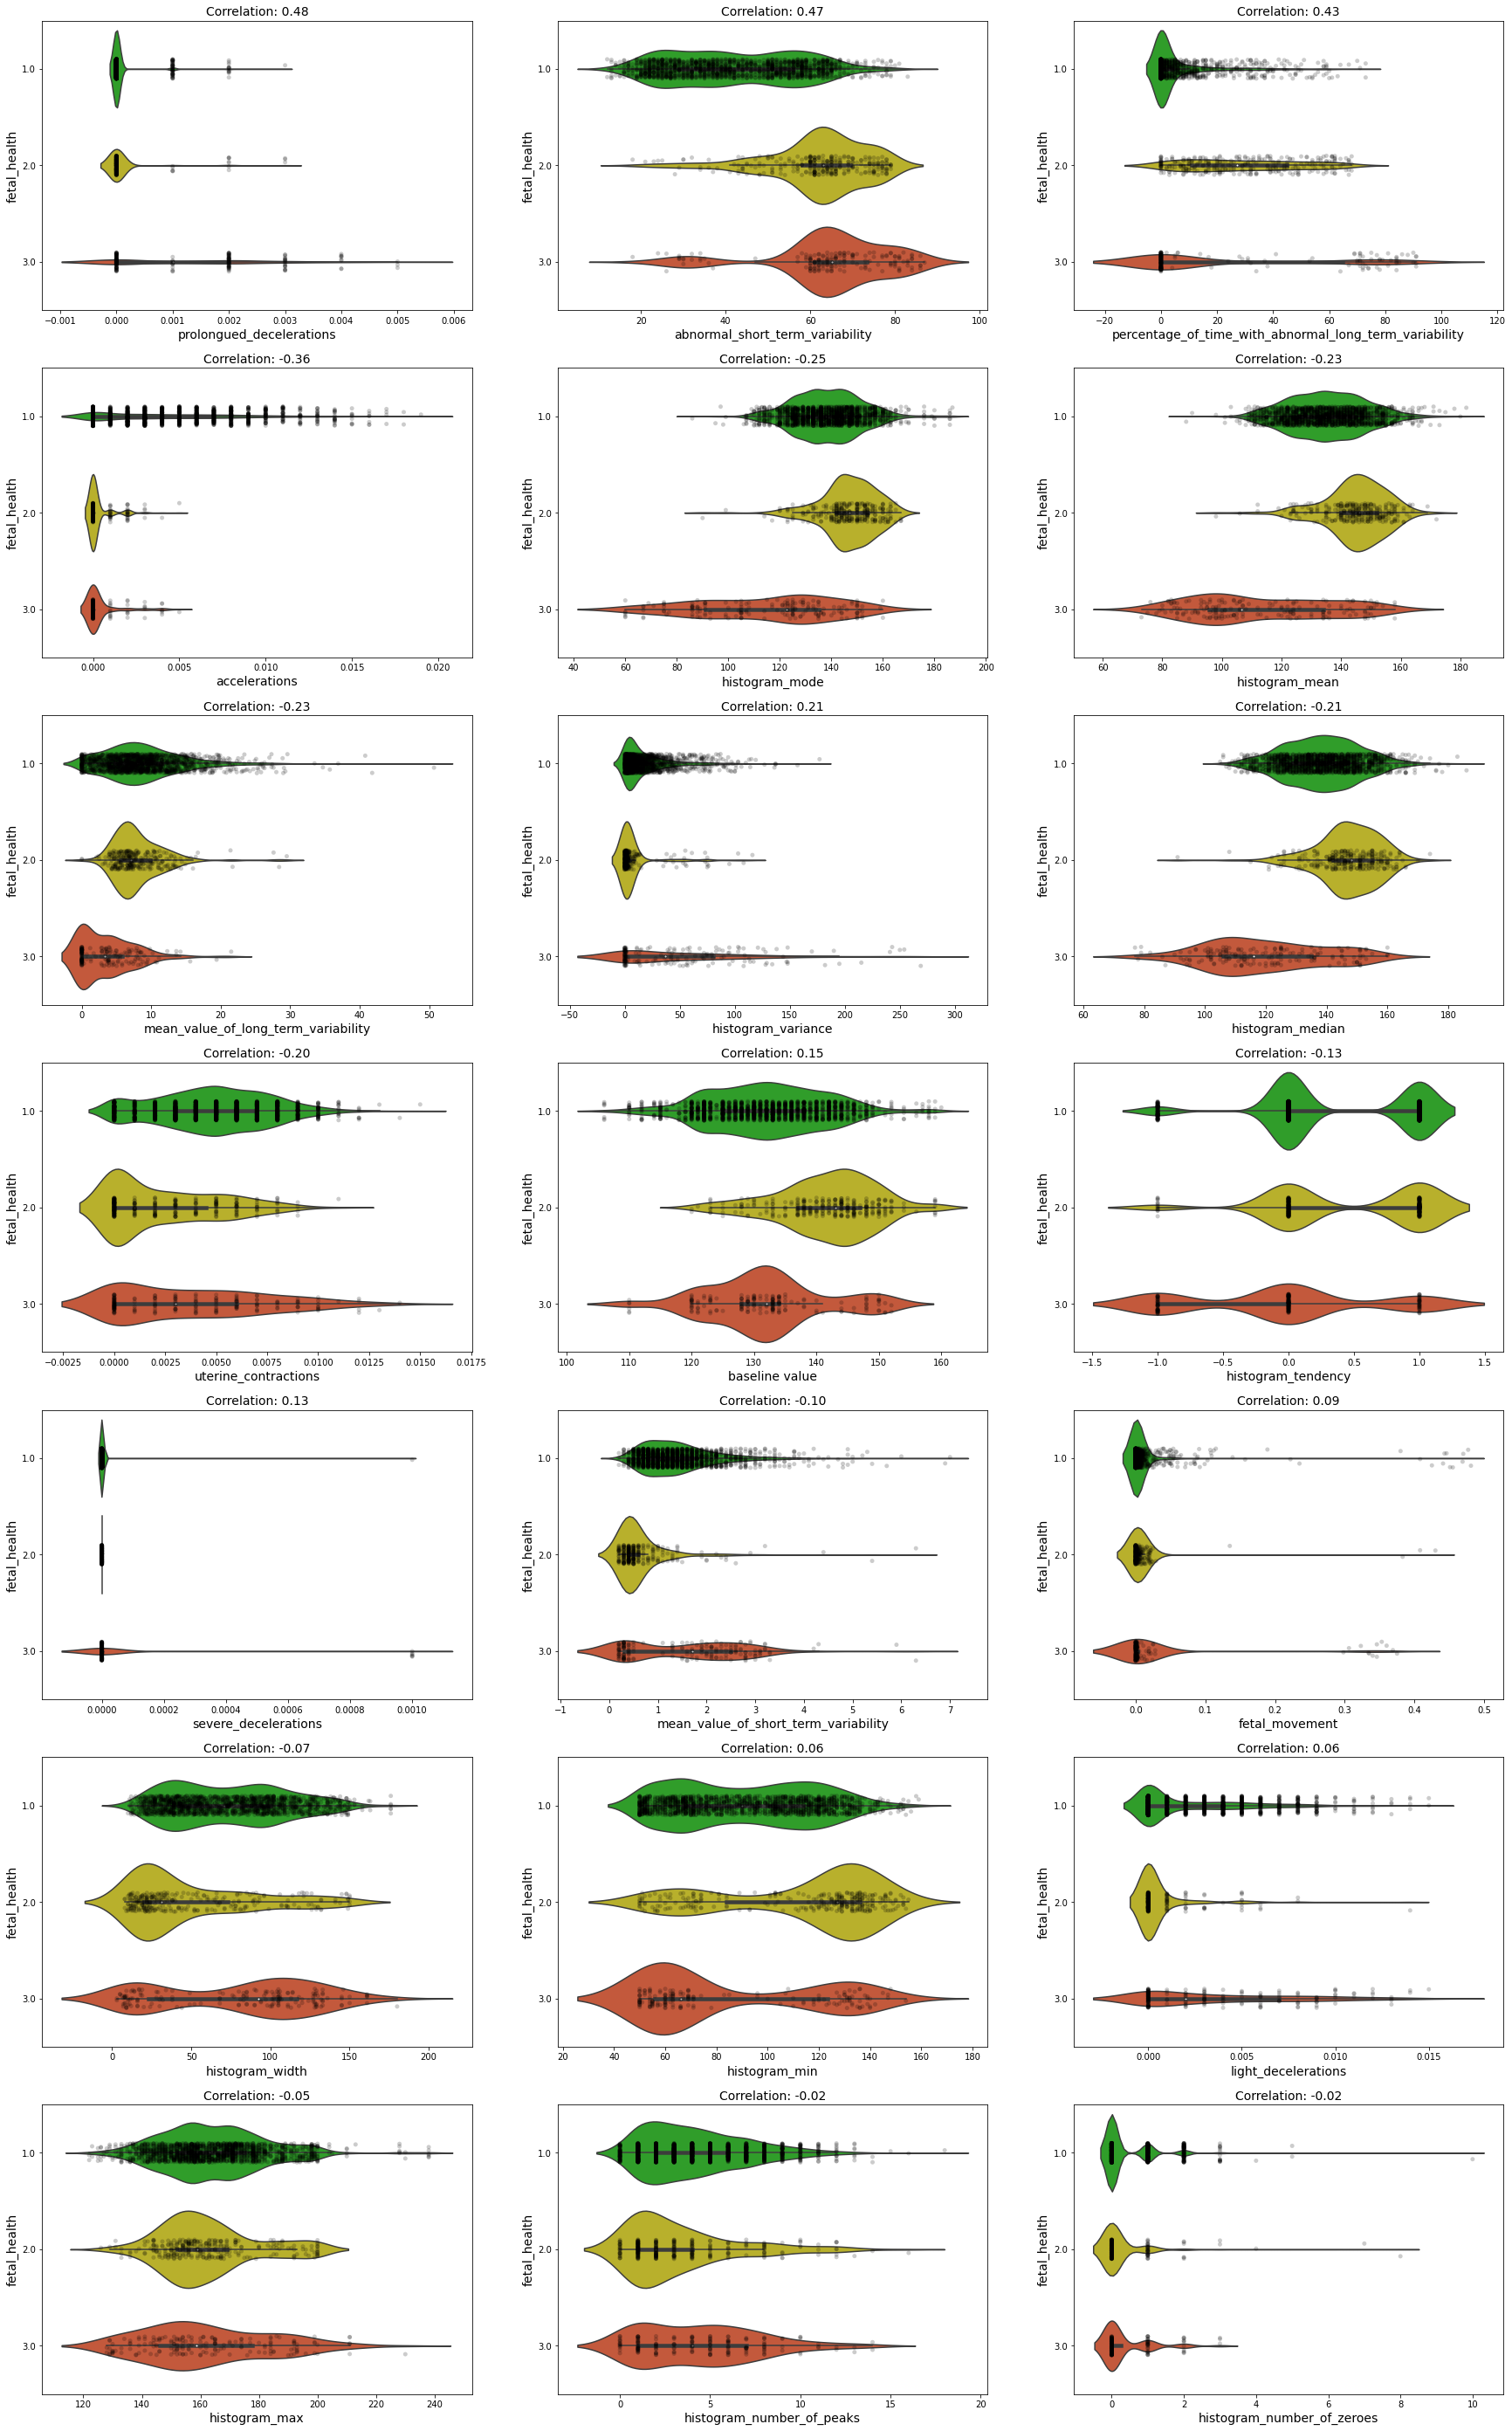

In [15]:
feature_names = fetal_health_corr.index.values
fetal_health_colors = {
    1:'#1fb017', # green for Normal
    2:'#cfc515', # yellow for Suspec
    3:'#d94c25' # red for Pathological
}

num_subplots = len(feature_names)
num_subplot_cols = 3
num_subplot_rows = int(np.ceil(num_subplots / num_subplot_cols))

position = range(1, num_subplots+1)
fig = plt.figure(figsize=(30,50))
y = fetal_df['fetal_health']
fig_col = 1
color_chooser = 0

for feature in feature_names:
    ax = fig.add_subplot(num_subplot_rows, num_subplot_cols, fig_col)
    x = fetal_df[feature]
    sns.violinplot(x=x, y=y, ax=ax, orient='h', palette=fetal_health_colors)
    sns.stripplot(x=x, y=y, ax=ax, orient='h', color='black', alpha=.2)
    corr = fetal_health_corr.loc[feature, 'fetal_health_correlation']
    plt.title(f"Correlation: {corr:.2f}", fontdict={'fontsize':14})
    plt.xlabel(feature, fontdict={'fontsize':14})
    plt.ylabel('fetal_health', fontdict={'fontsize':14})
    fig_col+=1
    color_chooser+=1
    if color_chooser >= num_subplots:
        color_chooser = 0
    else:
        continue
    if fig_col > num_subplots:
        break
    else:
        continue


#### Interpretation

> Many of the distributions for each target classes and each of the features have a strong positive skew indicating that there are outliers in the data. Typically, when there are outliers we would want to analyze them to see if it was caused by error or if the anomoly really doesn't fit in the population of interest. 

> Depending on what it is that you want to predict and how the outlier got there, there are different options for handling. In our case, since the data comes from a study, was generated by a machine, and was interpreted by experts in the field of study I have strong confidence that the outliers are not in error and is in our population of interest. 

> Because I believe the outliers to hold valuable information, it may be beneficial to transform the data to reduce the severity of the outliers. The other option would be to use a model that is robust to outliers but this limits our options when it comes to model selection. 



### Bar Chart - Target Class Balance

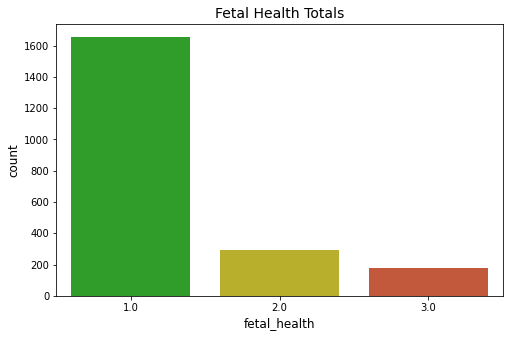

In [16]:
plt.figure(figsize=(8,5))
sns.countplot(x=y, palette=fetal_health_colors)
plt.title('Fetal Health Totals', fontdict=dict(fontsize=14))
plt.xlabel('fetal_health', fontdict=dict(fontsize=12))
plt.ylabel('count', fontdict=dict(fontsize=12))
plt.show()

In [17]:
target_class_prop_df = pd.DataFrame(fetal_df[['fetal_health']].value_counts(), columns=['Total'])
target_class_prop_df['Percent of Total'] = round(target_class_prop_df['Total'] / target_class_prop_df['Total'].sum(), 2)

target_class_prop_df

,Total,Percent of Total
fetal_health,,
1.0,1655,0.78
2.0,295,0.14
3.0,176,0.08


#### Interpretation

> There is imbalance in the target variable classes. Specifically, there are a lot more fetuses that have `Normal(1)` fetal health vs. fetuses with `Suspect(2)` or `Pathological(3)` fetal health. The probability for each of the target classes below:
1. Normal: 78%
2. Suspect: 14%
3. Pathological: 8%

> For this reason, if we were to try and predict `Pathological(3)` instances, the model could predict that **none** of the patients were Pathological and would still produce a model that is 92% accurate. This would produce a model with high Recall (*good at guessing non-Pathological*) and with low Precision (*bad at guessing Pathological*). 

> As with outliers, the first thing we should think about is if there is error in the data. As mentioned before however, because the data was collected by a machine and analyzed by experts I have strong confidence that the imbalance was not caused by error. 

> To address this, we would need to determine what the negative impact is of guessing certain classes incorrectly. Because the intent of the program is to reduce fetal and maternal mortality rates, I would imagine that we would want to be more "safe-than-sorry" and would weight False Positives being less important than potentially missing an acute care crisis (aka False Negative). This high negative impact from False Negatives will be incorporated into the model.

***

<br>

## References

<br>

Campos, A. (2022). SisPorto 2.0: a program for automated analysis of cardiotocograms. *The Journal of Maternal-Fetal Medicine, 9(5).* https://doi.org/10.1002/1520-6661(200009/10)9:5<311::AID-MFM12>3.0.CO;2-9

‌<br>

Larxel. (2017). *Fetal Health Classification.* Kaggle.com. https://www.kaggle.com/datasets/andrewmvd/fetal-health-classification

<br>

Xuereb, S. (2021). CTG Basics [YouTube Video]. In YouTube. https://www.youtube.com/watch?v=I5Dj9vKhlMQ

‌
‌